In [1]:
#! /usr/bin/python3

import os
import dendropy
from dendropy.calculate import treecompare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# input the path to the gon_phyling folder you wish to analyze
replicate_dir = ""

weighted_rfs_dict = {}
unweighted_rfs_dict = {}
replicate_count = 0
taxa_count = []

os.chdir(replicate_dir)

list_of_rep_dirs = []
dir_list = os.listdir(".")
for file in dir_list:
    if "combined_output-" in file:
        list_of_rep_dirs.append(file)
    else:
        continue

# looping through directories of runs
for dir_name in list_of_rep_dirs:
    os.chdir(dir_name)
    rep_files = os.listdir(".")
    phycord_best_trees = []
    gon_phy_best_trees = []
    
    replicate_count+=1
    
    unweighted_rfs_dict[replicate_count] = {}
    weighted_rfs_dict[replicate_count] = {}
    weighted_rfs = []
    unweighted_rfs = []
    
    for file in rep_files:
        if "RAxML_bestTree.phycorder-" in file:
            phycord_best_trees.append(file)
        elif "RAxML_bestTree.gon_phy-" in file:
            gon_phy_best_trees.append(file)
        else:
            continue
    
    phycord_best_trees.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    gon_phy_best_trees.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    
    #print("\n")
    #print("**")
    #print("NEW REPLICATE NUMBERS")
    #print("**")
    #print("\n")
    
    # looping through output files in directory
    for phycord_count, phycord_tree in enumerate(phycord_best_trees):
        tree_file_open = open(phycord_tree, 'r')
        read_tree = tree_file_open.read()
        step_count_taxa = read_tree.count("taxon")
        if step_count_taxa not in taxa_count:
            taxa_count.append(step_count_taxa)
        for gon_phy_count, gon_phy_tree in enumerate(gon_phy_best_trees):
            if phycord_count == gon_phy_count:
                
                
                # establish common taxon namespace
                tns = dendropy.TaxonNamespace()
                
                # ensure all trees loaded use common namespace
                tree1 = dendropy.Tree.get(
                path = gon_phy_tree,
                schema='newick',
                taxon_namespace=tns)

                tree2 = dendropy.Tree.get(
                path = phycord_tree,
                schema = 'newick',
                taxon_namespace = tns)
    
                best_tree_unweighted = treecompare.symmetric_difference(tree1, tree2)
                #print(best_tree_unweighted)
                unweighted_rfs.append(best_tree_unweighted)
                
                best_tree_weighted = treecompare.weighted_robinson_foulds_distance(tree1, tree2)
                #print(best_tree_weighted)
                weighted_rfs.append(best_tree_weighted)
                
    #print(unweighted_rfs)
    #print(weighted_rfs)
    #print(taxa_count)
    
    weight_temp_dict = {}
    for num1, count in enumerate(taxa_count):
        for num2, rf in enumerate(weighted_rfs):
            if num1 == num2:
                weight_temp_dict[count] = rf
    weighted_rfs_dict[replicate_count] = weight_temp_dict
    
    unweight_temp_dict = {}
    for num1, count in enumerate(taxa_count):
        for num2, rf in enumerate(unweighted_rfs):
            if num1 == num2:
                unweight_temp_dict[count] = rf
    unweighted_rfs_dict[replicate_count] = unweight_temp_dict
                
    os.chdir(replicate_dir)
#print(unweighted_rfs_dict)
#print(weighted_rfs_dict)

unweighted_df = pd.DataFrame.from_dict(unweighted_rfs_dict ,orient='columns')
weighted_df = pd.DataFrame.from_dict(weighted_rfs_dict,orient='columns')
unweighted_df.head()

,1,2
80,30,26
120,48,48
160,46,54
200,86,86
209,104,102


In [48]:
unweighted_df['mean rf'] = unweighted_df.mean(axis=1)
unweighted_mean = unweighted_df['mean rf']
unweighted_df['std'] = unweighted_df.std(axis=1)
unweighted_df.head()

#unweighted_mean.plot()

,1,2,mean rf,std
80,30,26,28.0,2.0
120,48,48,48.0,0.0
160,46,54,50.0,4.0
200,86,86,86.0,0.0
209,104,102,103.0,1.0


In [49]:
weighted_df['mean rf'] = weighted_df.mean(axis=1)
weighted_mean = weighted_df['mean rf']
weighted_df['std'] = weighted_df.std(axis=1)
weighted_df.head()

,1,2,mean rf,std
80,0.002556,0.002879,0.002717,0.000161
120,0.006113,0.006211,0.006162,0.000049
160,0.006310,0.006262,0.006286,0.000024
200,0.007067,0.007120,0.007093,0.000026
209,0.007444,0.007567,0.007505,0.000062


In [50]:
unweighted_df['isolate number'] = unweighted_df.index
unweighted_df.head()

,1,2,mean rf,std,isolate number
80,30,26,28.0,2.0,80
120,48,48,48.0,0.0,120
160,46,54,50.0,4.0,160
200,86,86,86.0,0.0,200
209,104,102,103.0,1.0,209


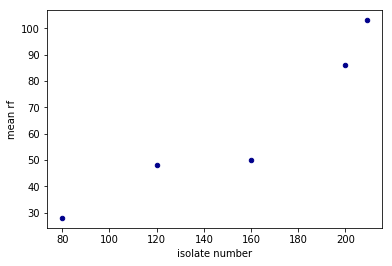

In [51]:
ax1 = unweighted_df.plot.scatter(x='isolate number',y='mean rf',c='DarkBlue')